In [ ]:
import numpy as np
import csv
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt

In [ ]:
import camera_tools as ct

In [ ]:
from cmac2 import CMAC

In [ ]:
#Calibrate the camera to detect green box, if you haven't done this calibration before
low_green, high_green = ct.colorpicker()
print(low_green)
print(high_green)

In [ ]:
low_red, high_red = ct.colorpicker()
print(low_red)
print(high_red)

In [ ]:
#Check whether the camera detects the green object properly
cam = ct.prepare_camera()
image = ct.capture_image(cam)
x,y = ct.locate(image, low_green, high_green)
ct.show_camera(cam)

print(x,y)

In [ ]:
#Check whether the camera detects the green object properly
cam_red = ct.prepare_camera()
img_red = ct.capture_image(cam_red)
ct.show_camera(cam_red, low_red, high_red)

In [ ]:
from FableAPI.fable_init import api
api.setup(blocking=True)

In [385]:
moduleids = api.discoverModules()
print("Module IDs: ", moduleids)
moduleID = moduleids[0]
print("Battery level:",api.getBattery(moduleID),"%")

Module IDs:  ['5YA ']
Battery level: 59.6 %


Dongle not ready!  (<class 'serial.serialutil.SerialException'>, SerialException("ClearCommError failed (PermissionError(13, 'The device does not recognize the command.', None, 22))"), <traceback object at 0x000001A76C7FBC00>)
5YA : Failed writing sync packet
Dongle not ready!  (<class 'serial.serialutil.SerialException'>, SerialException("ClearCommError failed (PermissionError(13, 'The device does not recognize the command.', None, 22))"), <traceback object at 0x000001A76C7B5C00>)
PORT: COM3, NAME: Standard Serial over Bluetooth link (COM3), HWID: BTHENUM\{00001101-0000-1000-8000-00805F9B34FB}_VID&0001005D_PID&223B\7&30FFFDFE&1&1C52169F0364_C00000000
PORT: COM4, NAME: Standard Serial over Bluetooth link (COM4), HWID: BTHENUM\{00001101-0000-1000-8000-00805F9B34FB}_LOCALMFG&0000\7&30FFFDFE&1&000000000000_00000000
Trying to connect - No devices found
PORT: COM3, NAME: Standard Serial over Bluetooth link (COM3), HWID: BTHENUM\{00001101-0000-1000-8000-00805F9B34FB}_VID&0001005D_PID&223B\7&

In [ ]:
api.setPos(-90,-90,moduleID)

In [ ]:
#Create two files (if they were not already created) to collect data.
if (not os.path.exists("xycoords_2.csv")):
    f = open('xycoords_2.csv', 'w')
    with f:
        writer = csv.writer(f)
        writer.writerows([["X","Y"]])
    f.close()
if (not os.path.exists("angles_2.csv")):
    f = open('angles_2.csv','w')
    with f:
        writer = csv.writer(f)
        writer.writerows([["Y_angle"]])
    f.close()

In [ ]:
#we use the collectData function to collect the data for training.
    #we collect Y (angular) position of the end effector
    #we collect x,y coordinates of the end effector in the camera image
    #see the video final_project_guidance.mp4
def collectData(desired_angle_change):
    cam = ct.prepare_camera()
    ct.show_camera(cam)
    cam.release()
    cam = ct.prepare_camera()
    api.setPos(-90,90,moduleID)
    api.sleep(1.5)
    Y_angle_list = []
    XY_coordinates_list = []
    traversed_directions = 0
    current_direction = 0     # 1 is for clockwise, 0 is for anticlockwise
    traversedDirections = 0
    num_of_iterations = (int)(np.round(360/desired_angle_change,1))
    #Fable's Y arm traverse anticlockwise
    if current_direction == 0:
        for i in range(num_of_iterations):
            img = ct.capture_image(cam)
            x,y = ct.locate(img, low_green, high_green)
            currentRobotYAng = (int)(np.round(api.getPos(1,moduleID),1))
            Y_angle_list.append([currentRobotYAng])
            XY_coordinates_list.append([x,y])
            currentRobotYAng = currentRobotYAng - (desired_angle_change)
            api.setPos(-90,currentRobotYAng,moduleID)
            api.sleep(1.5)
            if np.abs(currentRobotYAng) > 90:
                current_direction = 1
                traversedDirections = traversedDirections + 1
                break
    #Fable's Y Arm traverses clockwise
    if current_direction == 1:
        for i in range(num_of_iterations):
            img = ct.capture_image(cam)
            x,y = ct.locate(img, low_green, high_green)
            currentRobotYAng = (int)(np.round(api.getPos(1,moduleID),1))
            Y_angle_list.append([currentRobotYAng])
            XY_coordinates_list.append([x,y])
            currentRobotYAng = currentRobotYAng + (desired_angle_change)
            api.setPos(-90,currentRobotYAng,moduleID)
            api.sleep(1.5)
            if np.abs(currentRobotYAng) > 90:
                current_direction = 0
                traversedDirections = traversedDirections + 1
                break
    if traversedDirections == 2:
        cam.release()
        #Save collected data to files
        y_angle_file_ptr = open('angles_2.csv', 'a+', newline ='')
        with y_angle_file_ptr:
            writer = csv.writer(y_angle_file_ptr)
            writer.writerows(Y_angle_list)
        y_angle_file_ptr.close()
        file_xycoords = open('xycoords_2.csv', 'a+', newline ='')
        with file_xycoords:
            writer = csv.writer(file_xycoords)
            writer.writerows(XY_coordinates_list)
        file_xycoords.close()
    return
    

In [ ]:
#TODO: Call the CollectData() function with different values for 'desired_angle_change' argument and collect sufficient
#sufficient amout of data to angles_2.csv file and xycoords_2.csv file.
collectData(30)

In [ ]:
#Use this function to calculate Y (angular) position errors 
# Y (angular) positions
def readAngleFilesAndCollectErrors(fileName):
    angleDataFrame = pd.read_csv(fileName)
    desired_column = angleDataFrame.columns[0]
    angle_error_list = []
    for i in range(1,len(angleDataFrame)):
        current_data_element = angleDataFrame[desired_column][i]
        previous_data_element = angleDataFrame[desired_column][i-1]
        #TODO: Calculate the Y (angular) position error(say current_error) as the difference between 
        # the current Y (angular) position and previous Y (angular) position
        current_error = current_data_element - previous_data_element
        #print(current_data_element," ", previous_data_element, " ", current_error)
        angle_error_list = angle_error_list + [current_error]
    return angle_error_list

In [ ]:
#Use this function to calculate errors between x and y coordinates
def readXYCoordsFilesAndCollectErrors(fileName):
    xyCoordsDataFrame = pd.read_csv(fileName)
    x_col_name = xyCoordsDataFrame.columns[0]
    y_col_name = xyCoordsDataFrame.columns[1]
    x_pos_error_list = []
    y_pos_error_list = []
    for i in range(1,len(xyCoordsDataFrame)):
        current_data_element_x = xyCoordsDataFrame[x_col_name][i]
        current_data_element_y = xyCoordsDataFrame[y_col_name][i]
        previous_data_element_x = xyCoordsDataFrame[x_col_name][i-1]
        previous_data_element_y = xyCoordsDataFrame[y_col_name][i-1]
        error_x_pos = current_data_element_x - previous_data_element_x 
        error_y_pos = current_data_element_y - previous_data_element_y
        x_pos_error_list = x_pos_error_list + [error_x_pos]
        y_pos_error_list = y_pos_error_list + [error_y_pos] 
    return [x_pos_error_list,y_pos_error_list]

In [ ]:
#Read the provided files and load the calculated errors into to appropriate lists as follows
# angle_error_list_1 = readAngleFilesAndCollectErrors("angles_1.csv")
# x_pos_error_list_1,y_pos_error_list_1 = readXYCoordsFilesAndCollectErrors("xyCoords_1.csv")
#Read the files with the data dumped by you and load the calculated errors into appropriate lists.
angle_error_list_2 = readAngleFilesAndCollectErrors("angles_2.csv")
x_pos_error_list_2,y_pos_error_list_2 = readXYCoordsFilesAndCollectErrors("xyCoords_2.csv")

Remove any nans

In [ ]:
angle_error_list_2 = angle_error_list_2[1:]
x_pos_error_list_2 = x_pos_error_list_2[1:]
y_pos_error_list_2 = y_pos_error_list_2[1:]

In [ ]:
print(y_pos_error_list_2)

Standardize errors

In [ ]:
# mean_x_pos_1 = np.mean(x_pos_error_list_1)
# mean_y_pos_1 = np.mean(y_pos_error_list_1)
# std_x_pos_1 = np.std(x_pos_error_list_1)
# std_y_pos_1 = np.std(y_pos_error_list_1)
# x_pos_error_list_2 = np.array(x_pos_error_list_2[1:])
# mean_x_pos_2 = np.mean(x_pos_error_list_2)
# mean_y_pos_2 = np.mean(y_pos_error_list_2)
# std_x_pos_2 = np.std(x_pos_error_list_2)
# std_y_pos_2 = np.std(y_pos_error_list_2)
# print(mean_x_pos_2,mean_y_pos_2,std_x_pos_2,std_y_pos_2)

In [ ]:
# angle_error_list_1 = (angle_error_list_1 - np.mean(angle_error_list_1))/np.std(angle_error_list_1)
# x_pos_error_list_1 = (x_pos_error_list_1 - np.mean(x_pos_error_list_1,0))/np.std(x_pos_error_list_1,0)
# y_pos_error_list_1 = (y_pos_error_list_1 - np.mean(y_pos_error_list_1,0))/np.std(y_pos_error_list_1,0)
# # print("Angle error list 1: ",angle_error_list_1.shape)
# print("X position error list 1: ",x_pos_error_list_1.shape)
# print("Y position error list 1: ",y_pos_error_list_1.shape)
# angle_error_list_2 = (angle_error_list_2 - np.mean(angle_error_list_2))/np.std(angle_error_list_2)
#--------------------------------------
# x_pos_error_list_2 = (x_pos_error_list_2 - np.mean(x_pos_error_list_2))/np.std(x_pos_error_list_2)
# y_pos_error_list_2 = (y_pos_error_list_2 - np.mean(y_pos_error_list_2))/np.std(y_pos_error_list_2)
# print(x_pos_error_list_2)
# # print("Angle error list 2: ",angle_error_list_2.shape)
# print("X position error list 2: ",x_pos_error_list_2.shape)
# print("Y position error list 2: ",y_pos_error_list_2.shape)
x_coord_error_array = np.array(x_pos_error_list_2)
y_coord_error_array = np.array(y_pos_error_list_2)
angle_error_array = np.array(angle_error_list_2)

# Get a boolean mask where True indicates the location of NaNs in angle_error_array
nan_mask = np.isnan(x_coord_error_array)

# Use this mask to remove corresponding elements from x_coord_error_array and y_coord_error_array
x_coord_error_array = x_coord_error_array[~nan_mask]
y_coord_error_array = y_coord_error_array[~nan_mask]

# Now remove the NaNs from angle_error_array
angle_error_array = angle_error_array[~nan_mask]

print(angle_error_array.shape, x_coord_error_array.shape, y_coord_error_array.shape)

Merge them

In [ ]:
# # angle_error_array = np.concatenate((angle_error_list_1,angle_error_list_2),axis=0)
# x_coord_error_array = np.concatenate((x_pos_error_list_1,x_pos_error_list_2),axis=0)
# y_coord_error_array = np.concatenate((y_pos_error_list_1,y_pos_error_list_2),axis=0)
# print("Angle error array: ",angle_error_array.shape)
# print("X position error array: ",x_coord_error_array.shape)
# print("Y position error array: ",y_coord_error_array.shape)

In [ ]:
# #merge both angle_error_list_1 and angle_error_list_2 to a single list and make it a numpy array called 'angle_error_array'
# # angle_error_array = np.array(angle_error_list_1 + angle_error_list_2 )
# angle_error_array = angle_error_list_2
# #merge both x_pos_error_list_1 and x_pos_error_list_2 to a single list and make it a numpy array called 'x_coord_error_array'
# # x_coord_error_array = np.array(x_pos_error_list_1 + x_pos_error_list_2)
# x_coord_error_array = x_pos_error_list_2
# #merge both y_pos_error_list_1 and y_pos_error_list_2 to a single list and make it a numpy array called 'y_coord_error_array'
# # y_coord_error_array = np.array(y_pos_error_list_1 + y_pos_error_list_2)
# y_coord_error_array = y_pos_error_list_2

In [ ]:
# data = np.array([angle_error_array,x_coord_error_array,y_coord_error_array])
# target = np.array([angle_error_array,x_coord_error_array,y_coord_error_array])

In [ ]:
# Here we use 80% of the collected data  as the training set and 20% of the collected data as test set.
#TODO: Assign different propotions of the collected data set and test set and check how the test set error varies of the 
#Neural Network
data =  np.vstack((x_coord_error_array,y_coord_error_array)).T
target = np.vstack(angle_error_array)
# print(data)
# print(target)
data_input_tensor = torch.tensor(data.tolist()).float()
data_target_tensor = torch.tensor(target.tolist()).float()
data_with_target = torch.cat((data_input_tensor,data_target_tensor),1)
#TODO: what is the importance of using DataLoader utility function here?
loader= torch.utils.data.DataLoader(data_with_target,
                                     batch_size=data_with_target.size()[0], shuffle=True,
                                     num_workers=0)
#training set
train_set = []
#test set
test_set = []
for i in iter(loader):
    train_set_index = (int)(np.round(i.shape[0]*0.8))
    train_set = i[:train_set_index,:]
    test_set = i[train_set_index:,:]

In [ ]:
print(train_set.shape)
print(test_set.shape)

In [ ]:
#Defining Neural Network Model
class NN(torch.nn.Module):
    def __init__(self,n_feature,n_hidden1,n_hidden2,n_output):
        super(NN,self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature,n_hidden1)
        #self.do1 = torch.nn.Dropout(0.15)
        #self.relu1 = torch.nn.LeakyReLU()
        #self.bn1 = torch.nn.BatchNorm1d(n_hidden1,affine=False)
        self.hidden2 = torch.nn.Linear(n_hidden1,n_hidden2)
        #self.bn2 = torch.nn.BatchNorm1d(n_hidden2,affine=False)
        #self.relu2 = torch.nn.LeakyReLU()
        #self.do2 = torch.nn.Dropout(0.1)
        self.predict = torch.nn.Linear(n_hidden2,n_output)
        
        
    def forward(self,x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        #x = self.do1(x)
        x = self.hidden2(x)
        x = torch.sigmoid(x)
        #x = self.do2(x)
        x = self.predict(x)
        return x

In [ ]:
#instantiate the Neural Network
#model = NN(n_feature=2,n_hidden1=17,n_hidden2=7, n_output=1)
model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)

In [ ]:
#Define loss function : 
# here we use Mean Square Error as the loss function
loss_func = torch.nn.MSELoss()

In [ ]:
#Define the optimizer that should be used in training the Neural Network.
# Here 'lr' is the learning rate
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [ ]:
train_set_inputs = train_set[:,:2]
#TODO: calculate the mean value of the train_set_inputs. 
mean_of_train_input = torch.mean(train_set_inputs,0)
#standard deviation of the train set inputs.
std_of_the_train_input = torch.std(train_set_inputs,0)
#here we normalize the inputs of the neural network. What is the importance of that?
normalized_train_set_inputs = (train_set_inputs - mean_of_train_input)/std_of_the_train_input

In [ ]:
#targets of the training set
train_set_targets = train_set[:,2][:,np.newaxis]
# train_set_inputs = train_set[:,:2]

In [ ]:
print(normalized_train_set_inputs.shape)
print(train_set_targets.shape)
# print(train_set_inputs)
# print(train_set_targets)

In [ ]:
#TODO: train the Neural network model by changing the hyper parameters such as learning rate, number of epochs, number of neurons in hidden layers of the neural network.
# What is the minimum mean square error that you can achieve as your neural network converges for the training set.
#  (you will be able to achive a MSE of less than 10 as the Neural network converges.)
num_epochs = 2000
losslist = []
for _ in range(num_epochs):
    with torch.autocast(device_type="cpu", dtype=torch.bfloat16):
        prediction = model(normalized_train_set_inputs) # Forward pass prediction. Saves intermediary values required for backwards pass
        loss = loss_func(prediction, train_set_targets) # Computes the loss for each example, using the loss function defined above
    optimizer.zero_grad() # Clears gradients from previous iteration
    loss.backward() # Backpropagation of errors through the network
    optimizer.step() # Updating weights
    # print("prediction =",prediction)
    # print("Loss: ", loss.detach().numpy())
    losslist.append(loss.detach().numpy())

In [ ]:
print("Loss: ", losslist)

In [ ]:
#plot the mean square error in each epoch/iteration
plt.plot(np.arange(len(losslist)),losslist)
plt.show()

In [ ]:
#save the best neural network model you have obtained.
torch.save(model.state_dict(), 'best_nn_model.pth')

#Save the mean and standard deviation of the train set inputs because we need to use them at test time.

In [ ]:
#reload the your best neural network model with saved parameters
model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)
model.load_state_dict(torch.load('best_nn_model.pth'))

In [ ]:
#TODO: Extract inputs of the test_set
test_set_inputs = test_set[:,:2]
#TODO: Extract test set targets from the test_set
test_set_targets = test_set[:,2][:,np.newaxis]
print(test_set_inputs)

In [ ]:
#TODO: Normalize test set inputs by using the mean and standard deviation of the inputs of the training set
# train_numpy = train_set_inputs.numpy()
# mean_of_train_input = np.mean(train_numpy, axis = 0)
# print(test_numpy)
# print(mean_of_test_input)
# std_of_the_train_input = np.std(train_numpy,0)
normalized_test_set_inputs = (test_set_inputs - mean_of_train_input)/std_of_the_train_input
print(normalized_test_set_inputs)

In [ ]:
#TODO: feed the normalized test set inputs to the Neural Network model and obtain the prediction for the test set.
prediction_test = model(normalized_test_set_inputs)

In [ ]:
print(prediction_test.shape)

In [ ]:
#plot the prediction error of the test set
test_set_prediction_error = prediction_test - test_set_targets
print(prediction_test)
# print(test_set_prediction_error)
plt.plot(np.arange(len(test_set_prediction_error.tolist())),test_set_prediction_error.tolist())

In [ ]:
# In the example model trained with about 600 data, from a test set of 165 samples,
# 159 samples are predicted with prediction error less than 10.

In [ ]:
#TODO: Based on the prediction error of the test set, you can try to train the neural network again by changing the hyper parameters mentioned above.
# Also Try to add Dropout layers to the Neural network and check whether test prediction errors can be reduced further.

# DETECTING THE OBJECT AT TESTING PHASE

In [418]:
A = 100
T = 500

In [392]:
#Here we implement the control loop which is having Neural Network as the controller.
#In this case we donot integrate CMAC to the control loop
def ControlLoopWithNNWithoutCMAC(target__x_coordinate,target__y_coordinate):
    
    api.setPos(-90,0,moduleID)

    x_ref_vec = []
    x_act_vec = []

    number_of_iterations_for_convergence = 0
    #TODO:Intialize your best neural network model and load the saved paramemeters
    NN_model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)
    NN_model.load_state_dict(torch.load('best_nn_model.pth'))

    #TODO: Obtain the x and y coodinates of the green box placed on the end effector of the robot
    x_prev = 0
    y_prev = 0
    
    #Here we loop for 50 iterations assuming that 
    # the controller should achieve the desired target within atmost 50 iterations
    for i in range(100):
        cam = ct.prepare_camera()
        img = ct.capture_image(cam)
        x,y = ct.locate(img,low_green, high_green)

        # cam_red = ct.prepare_camera()
        # img_red = ct.capture_image(cam)
        # x_red,y_red = ct.locate(img,low_red, high_red)
        # print(x,y)

        x_ref = A * np.sin(2*np.pi * i/T) + 290
        y_ref = y

        x_ref_vec.append(x_ref)
        x_act_vec.append(x)

        print(i, x, x_ref)

        x_ref = float(x_ref)
        y_ref = float(y_ref)

        robot_x_coord_in_image = x
        robot_y_coord_in_image = y
        x_coord_error = x_ref - robot_x_coord_in_image;
        y_coord_error = y_ref - robot_y_coord_in_image;
        # print(x_coord_error,y_coord_error)
        # x_coord_error = (x_coord_error-mean_x_pos_2)/std_x_pos_2
        # y_coord_error = (y_coord_error-mean_y_pos_2)/std_y_pos_2
        x_prev = x_coord_error
        y_prev = y_coord_error
        # print(x_coord_error, y_coord_error)
        #Here if the errors are less than twenty pixels we assume robot reaches the target. 
        # However you can choose any reasonable threshold value instead of 20.
        # if (np.abs(x_coord_error) < (1+x_prev*1.02) and np.abs(y_coord_error) < (1+y_coord_error*1.02)):
        #     print("number of iterations for convergence = ", number_of_iterations_for_convergence)
        #     break
        xy_input_nn_model = [x_coord_error, y_coord_error]
        # print(xy_input_nn_model)
        # xy_input_nn_model = np.array(xy_input_nn_model)
        #TODO: normalize the input to the Neural network model using meaning and variance of the training set inputs.
        normalize_xy_input_nn_model = (torch.tensor(xy_input_nn_model) - mean_of_train_input)/std_of_the_train_input
        # normalize_xy_input_nn_model = xy_input_nn_model
        # print(normalize_xy_input_nn_model)
        # normalize_xy_input_nn_model_tensor = torch.tensor(normalize_xy_input_nn_model.tolist()).float()
        # print(normalize_xy_input_nn_model_tensor)
        prediction_for_Y_pos_increment = NN_model(normalize_xy_input_nn_model)
        # print(prediction_for_Y_pos_increment)
        #TODO: Get the current Y (angular) position/angle of the robot. you can use the api.getPos function of fable
        robot_current_Y_pos = api.getPos(1,moduleID)
        #Next Y angular position of the robot will be robot_Y_pos + prediction_for_Y_pos_increment
        robot_next_Y_pos = robot_current_Y_pos + prediction_for_Y_pos_increment
        # print(robot_next_Y_pos)
        #TODO: Set the next position of the robot to (-90,robot_next_Y_pos) using the setPos function of the fable.
        api.setPos(-90,robot_next_Y_pos,moduleID)
        api.sleep(1)
        number_of_iterations_for_convergence = number_of_iterations_for_convergence + 1

    return [x_ref_vec,x_act_vec]


In [413]:
#TODO: Detect the target object and obtain the coordinates of the object in the image
cam = ct.prepare_camera()
img = ct.capture_image(cam)
# ct.show_camera(cam, low_green, high_green)
x,y = ct.locate(img, low_green, high_green)
print(x,y)
# target_x = x
# target_y = y
# print("target_x = ",target_x)
# print("target_y = ",target_y)

152 228


In [412]:
api.setPos(-90,90,moduleID)

0

In [393]:
#TODO: Call the control loop for a target which is detected. Record the number of iterations that the control loop spent for convergence.
[x_ref_vec, x_act_vec] = ControlLoopWithNNWithoutCMAC(target_x,target_y)
#TODO: change your target location and try again. You may change the target 4-5 times and check how the control loop work.
#Record the number of iterations that the control loop spent for convergence.

324 290.0
262 291.63358518483585
294 293.26691240763387
290 294.8997237470915
304 296.53176136337004
296 298.1627675388107
306 299.7924847186313
298 301.4206555515966
312 303.04702293065793
304 304.67133003355264
298 306.29332036335956
312 307.91273778900296
304 309.5293265856984
318 311.14283147533484
310 312.75299766678586
324 314.3595708961442
314 315.96229746687294
322 317.5609242898671
316 319.15519892341956
330 320.74486961308423
320 322.3296853314311
332 323.9093958176866
326 325.48375161725227
320 327.0525041210969
334 328.61540560501453
326 330.17220926874313
340 331.72266927493723
334 333.2665407879883
328 334.80358001268723
340 336.3335442327226
334 337.85619184900816
348 339.37128241783415
340 340.87857668883635
334 342.3778366427762
348 343.8688255291269
340 345.3513079034594
352 346.82504966462125
346 348.2898180917042
356 349.7453818807934
352 351.19151118149324
346 352.627977633223
358 354.05455440127787
352 355.4710162126489
366 356.87713939159585
358 358.2727018949684

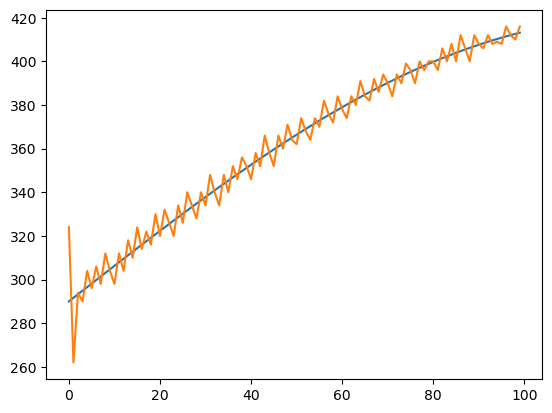

In [394]:
plt.plot(np.arange(len(x_ref_vec)),x_ref_vec)
plt.plot(np.arange(len(x_act_vec)),x_act_vec)
plt.show()

In [420]:
#Now integrate the CMAC to the previous control loop which had only the Neural Network. 
#The implementation of the CMAC can be found in code given for second week exercises.
#TODO: Implement the control loop with both neural network and CMAC. 
def ControlLoopWithBothNNandCMAC(target_x, target_y, iter_num):
    
    api.setPos(-90,0,moduleID)
    target_x_coord = target_x
    target_y_coord = target_y

    x_ref_vec = []
    x_act_vec = []

    number_of_iterations_for_convergence = 0
    max_iter = iter_num
    #TODO:Intialize your best neural network model and load the saved paramemeters
    NN_model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)
    NN_model.load_state_dict(torch.load('best_nn_model.pth'))

    ## TODO: CMAC initialization
    n_rfs = 1
    beta = 0.05

    xmin = [152,152]
    xmax = [448, 448]
    xavg = [(xmax[0]+xmin[0])/2, (xmax[1]+xmin[1])/2]

    xmin_cmac = [-1,-1]
    xmax_cmac = [1,1]

    c = CMAC(n_rfs, xmin, xmax, beta)

    ## Simulation loop
    for i in range(max_iter):
       
        cam = ct.prepare_camera()
        img = ct.capture_image(cam)
        x,y = ct.locate(img,low_green, high_green)
        # cam_red = ct.prepare_camera()
        # img_red = ct.capture_image(cam)
        # x_red,y_red = ct.locate(img,low_red, high_red)

        x_ref = A * np.sin(2*np.pi * i/T) + 300
        y_ref = y

        # print(i, x, x_ref)

        x_ref = float(x_ref)
        y_ref = float(x)

        x_ref_vec.append(x_ref)
        x_act_vec.append(x)

        # print(x,y)
        robot_x_coord_in_image = x
        robot_y_coord_in_image = y
        x_coord_error = x_ref - robot_x_coord_in_image;
        y_coord_error = y_ref - robot_y_coord_in_image;
        # print(x_coord_error,y_coord_error)
        # x_coord_error = (x_coord_error-mean_x_pos_2)/std_x_pos_2
        # y_coord_error = (y_coord_error-mean_y_pos_2)/std_y_pos_2
        x_prev = x_coord_error
        y_prev = y_coord_error
        
        ## TODO: Implement the CMAC controller into the loop
        
        #standardize the cmac input
        # x_ref = (x_ref - xavg[0])/(xmax[0] - xmin[0])
        # robot_x_coord_in_image = (robot_x_coord_in_image - xavg[1])/(xmax[1] - xmin[1])
        x_cmac = [x_ref ,robot_x_coord_in_image]
        angle_cmac = c.predict(x_cmac)

        print(x_cmac)

        # Iterate simulation dynamics
        
    
        #Here if the errors are less than twenty pixels we assume robot reaches the target. 
        # However you can choose any reasonable threshold value instead of 20.
        # if (np.abs(x_coord_error) < (1+x_prev*1.02) and np.abs(y_coord_error) < (1+y_coord_error*1.02)):
        #     print("number of iterations for convergence = ", number_of_iterations_for_convergence)
        #     break
        
        xy_input_nn_model = [x_coord_error,y_coord_error]
        # print(xy_input_nn_model)
        # xy_input_nn_model = np.array(xy_input_nn_model)
        #TODO: normalize the input to the Neural network model using meaning and variance of the training set inputs.
        normalize_xy_input_nn_model = (torch.tensor(xy_input_nn_model) - mean_of_train_input)/std_of_the_train_input
        # normalize_xy_input_nn_model = xy_input_nn_model
        # print(normalize_xy_input_nn_model)
        # normalize_xy_input_nn_model_tensor = torch.tensor(normalize_xy_input_nn_model.tolist()).float()
        # print(normalize_xy_input_nn_model_tensor)
        prediction_for_Y_pos_increment = NN_model(normalize_xy_input_nn_model)
        # print(prediction_for_Y_pos_increment)
        #TODO: Get the current Y (angular) position/angle of the robot. you can use the api.getPos function of fable
        robot_current_Y_pos = api.getPos(1,moduleID)
        #Next Y angular position of the robot will be robot_Y_pos + prediction_for_Y_pos_increment
        robot_next_Y_pos = robot_current_Y_pos + prediction_for_Y_pos_increment
        # print(robot_next_Y_pos)
        # print(prediction_for_Y_pos_increment.detach().numpy())
        c.learn(robot_next_Y_pos.detach().numpy())
        # print(angle_cmac)
        robot_nn_and_cmac = robot_next_Y_pos #+ angle_cmac

        #TODO: Set the next position of the robot to (-90,robot_next_Y_pos) using the setPos function of the fable.
        api.setPos(-90,robot_nn_and_cmac,moduleID)
        api.sleep(1)
        number_of_iterations_for_convergence = number_of_iterations_for_convergence + 1

    return [x_ref_vec,x_act_vec]

In [421]:
[x_ref_vec,x_act_vec] = ControlLoopWithBothNNandCMAC(0,0, 100)

[300.0, 288]
[301.25660398833526, 224]
[302.5130095443337, 334]
[303.76901826699344, 243]
[305.02443181797696, 288]
[306.27905195293135, 274]
[307.5326805527933, 288]
[308.7851196550743, 288]
[310.0361714851215, 288]
[311.2856384873482, 288]
[312.5333233564304, 292]
[313.7790290684638, 286]
[315.0225589120757, 296]
[316.26371651948836, 264]
[317.5023058975276, 316]
[318.73813145857247, 230]
[319.9709980514407, 338]
[321.2007109922055, 252]
[322.4270760949381, 355]
[323.64989970237247, 272]
[324.8689887164855, 304]
[326.0841506289897, 272]
[327.2951935517325, 306]
[328.50192624699764, 270]
[329.7041581577035, 314]
[330.90169943749476, 248]
[332.094360980721, 356]
[333.2819544522987, 272]
[334.46429231745174, 313]
[335.6411878713251, 260]
[336.8124552684678, 354]
[337.9779095521801, 272]
[339.13736668372024, 324]
[340.2906435713663, 252]
[341.4375580993284, 360]
[342.57792915650725, 278]
[343.7115766650933, 314]
[344.83832160900323, 302]
[345.9579860621488, 314]
[347.07039321653326, 308]

KeyboardInterrupt: 

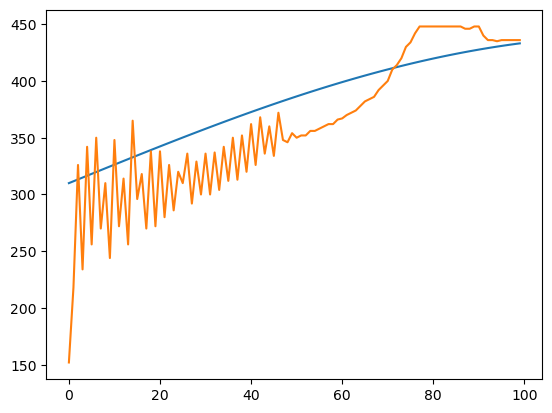

In [416]:
plt.plot(np.arange(len(x_ref_vec)),x_ref_vec)
plt.plot(np.arange(len(x_act_vec)),x_act_vec)
plt.show()

In [445]:
from adaptive_filter.cerebellum import AdaptiveFilterCerebellum


def NNwithAF(target_x, target_y, iter_num):

    target_x_coord = target_x
    target_y_coord = target_y
    number_of_iterations_for_convergence = 0
    max_iter = iter_num
    #TODO:Intialize your best neural network model and load the saved paramemeters
    NN_model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)
    NN_model.load_state_dict(torch.load('best_nn_model.pth'))

    x_ref_vec = []
    x_act_vec = []

    ## TODO: AF initialization
    Ts = 1
    n_inputs = 1
    n_outputs = 1
    n_bases = 10
    beta = 1e-4

    af = AdaptiveFilterCerebellum(Ts, n_inputs, n_outputs, n_bases, beta)

    robot_nn_and_af = 0
    robot_input = 0

    ## Simulation loop
    for i in range(max_iter):
       
        cam = ct.prepare_camera()
        img = ct.capture_image(cam)
        x,y = ct.locate(img,low_green, high_green)
        # cam_red = ct.prepare_camera()
        # img_red = ct.capture_image(cam)
        # x_red,y_red = ct.locate(img,low_red, high_red)

        x_ref = A * np.sin(2*np.pi * i/T) + 310
        y_ref = y

        # print(x, x_ref)

        x_ref = float(x_ref)
        y_ref = float(x)

        x_ref_vec.append(x_ref)
        x_act_vec.append(x)

        # print(x,y)
        robot_x_coord_in_image = x
        robot_y_coord_in_image = y
        x_coord_error = x_ref - robot_x_coord_in_image;
        y_coord_error = y_ref - robot_y_coord_in_image;
        # print(x_coord_error,y_coord_error)
        # x_coord_error = (x_coord_error-mean_x_pos_2)/std_x_pos_2
        # y_coord_error = (y_coord_error-mean_y_pos_2)/std_y_pos_2
        x_prev = x_coord_error
        y_prev = y_coord_error
        
        ## TODO: Implement the CMAC controller into the loop
       
        af_out = af.step(robot_input, x_coord_error)
        print(af_out)
        x_coord_error = x_coord_error +af_out
        # print(type(x_coord_error))
        y_coord_error = float(y_coord_error)
        # print(type(y_coord_error))
        # Iterate simulation dynamics
        
    
        #Here if the errors are less than twenty pixels we assume robot reaches the target. 
        # However you can choose any reasonable threshold value instead of 20.
        # if (np.abs(x_coord_error) < (1+x_prev*1.02) and np.abs(y_coord_error) < (1+y_coord_error*1.02)):
        #     print("number of iterations for convergence = ", number_of_iterations_for_convergence)
        #     break
        
        xy_input_nn_model = [x_coord_error,y_coord_error]
        # print(xy_input_nn_model)
        # xy_input_nn_model = np.array(xy_input_nn_model)
        # print(xy_input_nn_model)
        # xy_input_nn_model = float(xy_input_nn_model)
        # print(type(xy_input_nn_model[1]))
        #TODO: normalize the input to the Neural network model using meaning and variance of the training set inputs.
        normalize_xy_input_nn_model = (torch.tensor(xy_input_nn_model) - mean_of_train_input)/std_of_the_train_input
        # normalize_xy_input_nn_model = xy_input_nn_model
        # print(type(normalize_xy_input_nn_model))
        # normalize_xy_input_nn_model_tensor = torch.tensor(normalize_xy_input_nn_model.tolist()).float()
        # print(normalize_xy_input_nn_model_tensor)
        prediction_for_Y_pos_increment = NN_model(normalize_xy_input_nn_model)
        # print(prediction_for_Y_pos_increment)
        #TODO: Get the current Y (angular) position/angle of the robot. you can use the api.getPos function of fable
        robot_current_Y_pos = api.getPos(1,moduleID)
        #Next Y angular position of the robot will be robot_Y_pos + prediction_for_Y_pos_increment
        robot_next_Y_pos = robot_current_Y_pos + prediction_for_Y_pos_increment
        # print(robot_next_Y_pos)
        # print(prediction_for_Y_pos_increment.detach().numpy())
       
       
        robot_nn_and_af = robot_next_Y_pos
        robot_input = robot_nn_and_af.detach().numpy()

        #TODO: Set the next position of the robot to (-90,robot_next_Y_pos) using the setPos function of the fable.
        api.setPos(-90,robot_nn_and_af,moduleID)
        api.sleep(1)
        number_of_iterations_for_convergence = number_of_iterations_for_convergence + 1
        

    return [x_ref_vec,x_act_vec]

In [446]:
[x_ref_vec,x_act_vec] = NNwithAF(0,0, 180)

0.0
0.0
0.0
0.0
0.21197821752261314
1.3592709005833847
-0.4119861185195991
1.5732648272411358
-3.661498238022093
0.46378402463827295
2.4085604911351925
0.6687912746617539
3.4572802737767856
7.181870352682976
4.5191522905569705
9.707037234046698
14.785444318007027
12.432908669622218
21.006620536757655
23.502399419695294
23.94968291841784
35.65378686982344
37.07399873884477
38.85777317690841
52.05484742289124
50.38218071903169
57.426387997365424
66.60881816343596
62.299781243265706
64.38188304568075
68.13816086705158
60.79957396916279
58.17058289327089
58.87249032787114
56.0196948407386
53.08047651518959
57.25230004508671
59.00727113842528
57.59487633440124
63.97258183900707
67.1433935937557
63.63907070767004
65.59819918715016
66.82540208081514
63.49904794392475
63.87866971328677
65.72009781348974
64.9721451279365
65.12284820019829
65.93466155658982
67.66072577460822
66.99380307151563
71.34806141137672
72.99701052418214
73.6824780852234
72.70049566728467
73.36184755059126
71.233040509471

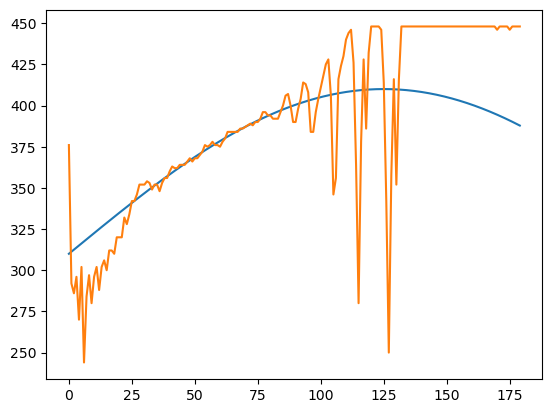

In [447]:
plt.plot(np.arange(len(x_ref_vec)),x_ref_vec)
plt.plot(np.arange(len(x_act_vec)),x_act_vec)
plt.show()

In [ ]:
#TODO: Compare the number of iteration it takes for convergence in the control loop with 
# neural network only and with both CMAC and neural network.